This notebook explores the idea of using weighted edges for better community detection on noisy graphs.Edge weights are learned using distance between node embedding. Modularity on weighted graph is then used to learn better communities.
The experiment up until now only checks if adding weights to edges affects the communities detected by the Louvian method.  
Note -     
\# - explains what code in the cell does  
\## - commented print and other code statements

In [ ]:
!pip install networkx
!pip install python-louvain

#### Community detection with the louvain method

In [127]:
#the warnings are because the package was compiled against an older version of numpy than is in use
import warnings
import sys
import community as louvain
import networkx as nx

from stellargraph import datasets
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec

import scipy as sp
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set()

warnings.filterwarnings("ignore",message="numpy.ufunc size changed")
warnings.filterwarnings("ignore",message="Passing (type, 1)")

#pd.__version__

#### Preliminary analysis
##### note on the libraries used : Stellargraph for graph machine learning, netwrokx for graph manipulation and graph algorithms

In [128]:
data = datasets.Cora() #loading the Cora dataset available in the stellargraph library
Graph_st,nodelabels = data.load() #loading the graph and the associated paper labels

Graph_nx = Graph_st.to_networkx() #making the graph object compatible with networkx
Graph_nx_embed = Graph_st.to_networkx() #making a copy of Graph_st 

Graph_st.info()

'StellarGraph: Undirected multigraph\n Nodes: 2708, Edges: 5429\n\n Node types:\n  paper: [2708]\n    Features: float32 vector, length 1433\n    Edge types: paper-cites->paper\n\n Edge types:\n    paper-cites->paper: [5429]\n        Weights: all 1 (default)\n        Features: none'

1.Graph_st is a multi graph with all edge weights = 1.0  
2.edges in multi graph in networkx have a 'key' value to distinguish one edge from another  
3.adjacency matrix of multi graphs have summation of weights of edges when nodes have multiple edges connecting them  

In [129]:
##for node/edges in the graph

#Graph_st.nodes()
#Graph_st.edges(include_edge_type=True, include_edge_weight = True)
#Graph_nx.edges(keys=True)

##To map node index to node labels and node labels to node index for exploratory tasks
n_nodes = len(Graph_st.nodes())

node_index = np.arange(0,n_nodes)
node_label = Graph_st.node_ilocs_to_ids(node_index)
node_index_to_label = dict(zip(node_index,node_label))
node_label_to_index = dict(zip(node_label,node_index))


##to get edges that are equal to a particular value
#edges = G.edges()
#edge_val = 13982
#[edge for edge in edges if edge_val in edge]

#### Louvian Method for community detection 

In [130]:
#computes the louvian parition and returns the partition and communities
#returns 'partion' dictionary of the form 'node id:community label' and 'communities' integer which
#is the number of communities detected

def partition_graph(Graph):
    
    partition = louvain.best_partition(Graph)
    communities = max(partition.values()) + 1
    
    return({'partition':partition,'communities':communities})

In [131]:
#returns a dictionary of nodes collected in each partition
def collect_nodes(partition):
    
    node_cluster = defaultdict(list)
    
    for node,cluster in partition.items():
        node_cluster[cluster].append(node)
    
    return(node_cluster)

In [132]:
#returns nodes assigned to different groups in communities detected with and without weighted edges learned from embeddings

def difference_community(partition1,partition2):
    
    relbpartition1 = relabel_community(partition1,partition2)
    diffcommunities = dict(set(relbpartition1.items()) ^ set(partition2.items())) # calculates symmetric differnce of sets
    
    return(diffcommunities)   

In [133]:
#relabels members of relabel partition with labels of members of usingpart

def relabel_community(relabelpart,usingpart):
    
    newlabel = dict()
    for key,val in relabelpart.items():
        if val not in newlabel.keys():
            newlabel[val] = usingpart[key]

    #map new community labels 
    for key,val in relabelpart.items():
        relabelpart[key] = newlabel[val]
        
    #assert(np.unique(partition2.values()) == np.unique(partition1.values()))
    
    return(relabelpart)

In [134]:
part_graph = partition_graph(Graph_nx)
part, num_communities = part_graph['partition'], part_graph['communities']
#nodes_by_communities = collect_nodes(part)
#print(part)
#print(num_communities)
#print(nodes_by_communities)

#### Community detection by learning weights using node embeddings

In [153]:
#generating random walks
randomwalk = BiasedRandomWalk(Graph_st)

walks = randomwalk.run(nodes = Graph_st.nodes(),
                      length = 40,
                      n = 10, #number of random walks from each node
                      p = 0.5, #p - return parameter
                      q = 2) #q - in-out parameter, #q > 1 BFS , #q < 1 DFS
print("Number of random walks",len(walks))

Number of random walks 27080


In [154]:
#converting walks to vector of words

walks_string = [[str(node) for node in walk] for walk in walks]
word2vec_model = Word2Vec(walks_string , size = 128 , window = 5, min_count = 0, sg = 1)
node_embeddings = (word2vec_model.wv.vectors)

In [137]:
##extracting embedding vector with node label
##word2vec_model.wv['35']

##### Learning edge weights based on distance between node embeddings

In [155]:
#getting adjacency matrix of the graph

adj_matrix = nx.adjacency_matrix(Graph_nx_embed, weight = 'weights')
adj_matrix_dense = adj_matrix.todense()

#checking for weights other than 0 in the dense matrix
##np.any(adj_matrix_dense == 1, axis = 1)
##np.any(adj_matrix_dense == 1, axis = 0)

In [156]:
#calculating the distance between every pair of node embeddings

node_index = np.arange(0,len(Graph_nx_embed.nodes)) #np.arange lists is half the size of list(range())
##node_labels_range = list(range(1,len(Graph.nodes)))
##print(sys.getsizeof(node_labels))
##print(sys.getsizeof(node_labels_range))

node_cartprod_df = pd.DataFrame(index = node_index, columns = node_index)

#euclidean distance of each embedding with all others
euclidean_cart = node_cartprod_df.apply(lambda col: np.linalg.norm(node_embeddings[col.name] - node_embeddings[col.index],axis = 1))

In [157]:
#learning weights based on euclidean distance of neighbours
#this method will 'not' take into consideration nodes which are not first degree neighbours
#the adjacency matrix is computed using ordered node labels
#axis = 0 refers to each column and axis = 1 refers to each row

euclidean_matrix = adj_matrix_dense*euclidean_cart

#calculating weights of each edge in the graph
weights = euclidean_matrix/ euclidean_matrix.max(axis=1)

In [158]:
#putting edge weights in the form ((node1,node2,key):{'weight':value})
edges = Graph_nx_embed.edges(keys = True)
edge_labels_to_weights = [{'weight':weights.iloc[node_label_to_index[edge[0]],node_label_to_index[edge[1]]]} for edge in edges]
edge_weights = dict(zip(edges,edge_labels_to_weights))

#updating weights 
nx.set_edge_attributes(Graph_nx_embed,edge_weights)
##Graph_nx_embed.edges(keys = True, data = True)

In [159]:
#ruuning the louvian method for community detection on weighted edges

part_embed_graph = partition_graph(Graph_nx_embed)
part_embed = part_embed_graph['partition']
num_communities_embed = part_embed_graph['communities']
##nodes_by_communities_embed = collect_nodes(part)
##print(part)
##print(num_communities_embed)
##print(nodes_by_communities_embed)

#### Checking difference in communities detected

In [160]:
diff_community = difference_community(part,part_embed)
##print(diff_community)

##### generating a comparitive plot of communities detected by the two methods

In [161]:
tsne = TSNE(n_components = 2)
transformed_embeddings = tsne.fit_transform(node_embeddings)

Plot of distribution of communities detected on unweighted edges

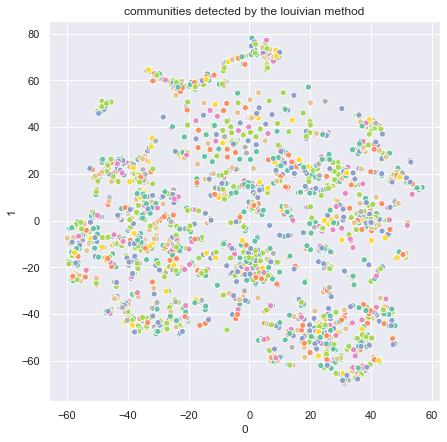

In [162]:
#plot of louvian communities detected on unweighted edges

df_louvian = pd.DataFrame(transformed_embeddings)
col_label = [0]*n_nodes
for node,community in part.items():
    col_label[node_label_to_index[node]] = community
    
df_louvian['label'] = col_label

sns.color_palette("Set2", 105)
sns.set_palette("Set2", 105)
plt.figure(figsize = (7,7))
plt.title("communities detected by the louivian method")
plt.xlabel("axis 1")
plt.ylabel("axis 2")
ax = sns.scatterplot(df_louvian[0], df_louvian[1], hue = df_louvian['label'], palette = "Set2", legend = False)

Plot of distribution of communities detected on weighted edges

Text(0, 0.5, 'axis 2')

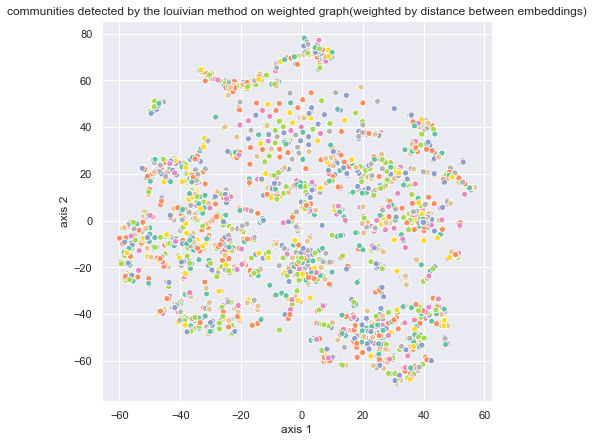

In [163]:
#plot of louvain communities on weighted edges

df_embed_louvian = pd.DataFrame(transformed_embeddings)
col_label_embed = [0]*n_nodes

for node,community in part_embed.items():
    col_label[node_label_to_index[node]] = community
    
df_embed_louvian['label'] = col_label

plt.figure(figsize = (7,7))
plt.title("communities detected by the louivian method on weighted graph(weighted by distance between embeddings)")
ax = sns.scatterplot(df_embed_louvian[0], df_embed_louvian[1], hue = df_embed_louvian['label'], palette="Set2", legend=False)
plt.xlabel("axis 1")
plt.ylabel("axis 2")

Comparitive plot of distribution of communities on unweighted and weighted edges

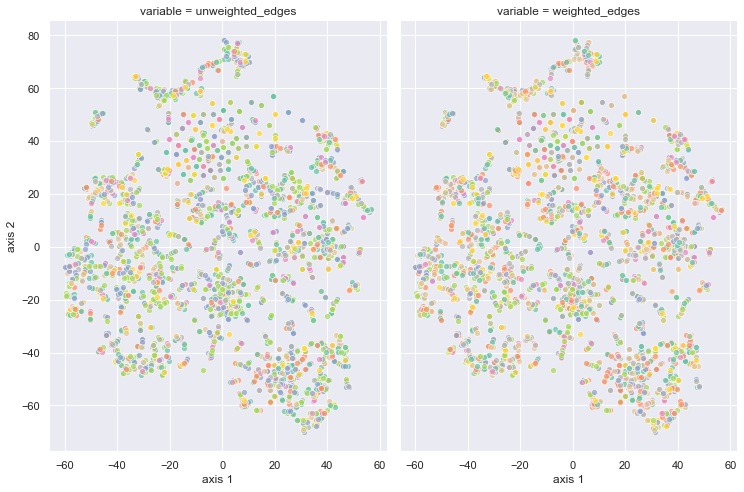

In [164]:
#comparitive plot of communities on unweighted and weighted edges
df_louvian = pd.DataFrame(transformed_embeddings)
col_label = [0]*n_nodes

col_label_embed = [0]*n_nodes

for node,community in part.items():
    col_label[node_label_to_index[node]] = community

for node,community in part_embed.items():
    col_label_embed[node_label_to_index[node]] = community
    
df_louvian['unweighted_edges'] = col_label
    
df_louvian['weighted_edges'] = col_label_embed

#df_louvian.stack().to_frame().reset_index().rename(columns = {0:'val'})
df_louvian_melt = pd.melt(df_louvian, id_vars = [0,1])
df_louvian_melt = df_louvian_melt.rename(columns = {0:'axis 1',1:'axis 2'})

#plotting the two graphs
g = sns.FacetGrid(df_louvian_melt, col="variable", hue="value", height = 7,aspect=0.75, legend_out = True) #width = aspect * height
g.map(sns.scatterplot, 'axis 1', 'axis 2' , alpha=.7)

Plot of difference in communities detected on unweighted and weighted graphs

Text(0, 0.5, 'axis 2')

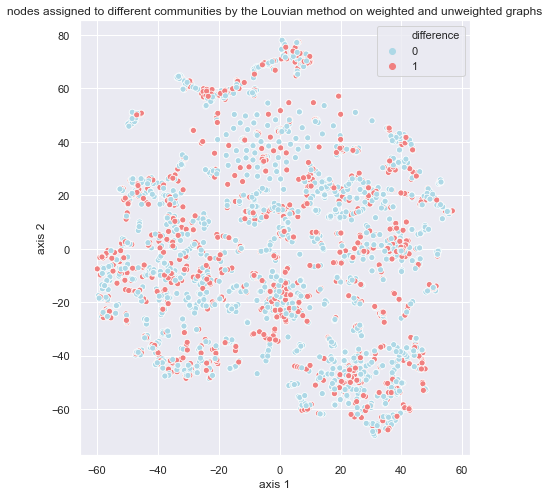

In [165]:
colors = ["lightblue", "lightcoral"]
sns.set_palette(sns.color_palette(colors))
#sns.set_palette(sns.color_palette("Paired"))

df_louvian['difference'] = 0
df_louvian.loc[abs(df_louvian['weighted_edges'] - df_louvian['unweighted_edges']) > 0,'difference'] = 1
df_plot = df_louvian[[0,1,'difference']]

plt.figure(figsize = (7,8))
plt.title("nodes assigned to different communities by the Louvian method on weighted and unweighted graphs")
ax = sns.scatterplot(df_plot[0], df_plot[1], hue = df_plot['difference'])
plt.xlabel("axis 1")
plt.ylabel("axis 2")